In [41]:
# Imports
import numpy as np
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
import sklearn
import lightgbm as lgb  # brew install lightgbm (on MacOS)
import pickle
from IPython.display import Image
from subprocess import call
from imblearn.over_sampling import SMOTE
import itertools

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load data

In [29]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(24421, 13) (24421, 13)


# Preprocessing

In [30]:
# One-hot-encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_train.shape, X_test.shape)

(24421, 102) (24421, 103)


In [31]:
# Dealing with imbalanced classes

# Generate synthetic samples
colnames_X = X_train.columns
sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=colnames)
y_train = pd.DataFrame(y_train, columns=["exceeds50K"])
print(X_train.shape, X_test.shape)

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(37120, 102) (24421, 103)


# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [ ]:
## Create a parameter grid for gridsearch

# Create the random grid
random_grid = {
    'objective': ['binary'],
    'num_leaves': [5, 10, 20, 50], 
    'min_data_in_leaf': [0, 10, 20, 40],
    'max_depth': [5, 10, 15],
    'max_bin': [5, 10, 25, 50],
    'learning_rate':[0.001, 0.01, 0.1],
    'dart': [True, False],
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100],
    'n_estimators': [1000, 5000, 10000],
    'bootstrap': [True, False]
        }
               
print(random_grid)

In [ ]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = lgb.LGBMClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
gb_gridsearch = RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_jobs=2,
                                   scoring="f1_weighted", n_iter=2000, cv=5, verbose=6, random_state=42)
# Fit the random searfch model
gb_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
gb_gridsearch.best_params_

In [5]:
best_params = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False,
    'class_weight': 'balanced'
}

In [7]:
## Evaluate improvment between the base model and the fine-tuned model
# 0.890393324319513 0.09260006799074111

base_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())


# best_model = gb_gridsearch.best_estimator_
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ....................... , score=0.7212984897980692, total=   0.7s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] ........................ , score=0.857151223801397, total=   0.7s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV] ....................... , score=0.9588502786163908, total=   0.6s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


[CV] ....................... , score=0.9589942253505056, total=   0.7s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


[CV] ....................... , score=0.9553344592611775, total=   0.8s
0.8903257353655081 0.09306757404030451
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s


[CV] ....................... , score=0.7223192117725677, total=  21.4s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.4s remaining:    0.0s


[CV] ....................... , score=0.8571438588919764, total=  20.0s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV] ....................... , score=0.9589865261713275, total=  19.9s
[CV]  ................................................................


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV] ....................... , score=0.9584504028431609, total=  22.2s
[CV]  ................................................................
[CV] ....................... , score=0.9550666219185335, total=  18.8s
0.890393324319513 0.09260006799074111
Improvement of 0.01%.


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


# Validation split 

In [50]:
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
model = lgb.LGBMClassifier(**best_params, random_state=42)
model.fit(X_training, y_training)
y_prediction = model.predict(X_validation)
print(f1_score(y_validation, y_prediction))
print(f1_score(y_validation, y_prediction, average='micro'))

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9093493895300218
0.9115102040816326


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[5729  383]
 [ 701 5437]]
Normalized confusion matrix
[[93.73  6.27]
 [11.42 88.58]]


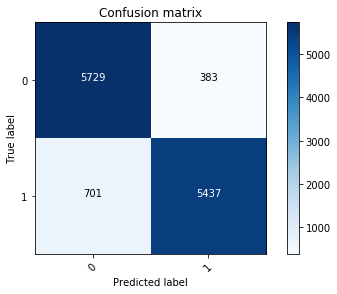

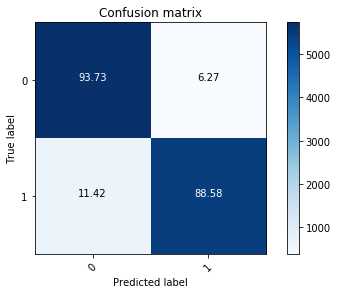

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm =  np.round(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix(y_true=y_validation, y_pred=y_prediction), classes=["0", "1"])
plt.figure()
plot_confusion_matrix(confusion_matrix(y_true=y_validation, y_pred=y_prediction), classes=["0", "1"], normalize=True)

# Train on whole dataset using optimised set of parameters

In [12]:
# final_model = lgb.LGBMClassifier(**gb_gridsearch.best_params_, random_state=42
final_model = lgb.LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight='balanced',
        colsample_bytree=1.0, dart=False, importance_type='split',
        learning_rate=0.01, max_bin=50, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=10, objective='binary',
        random_state=42, reg_alpha=0.1, reg_lambda=100, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Predict on test and save

In [13]:
# issue: one country 'native-country_ Holand-Netherlands' in test but not in train
X_test = X_test.drop('native-country_ Holand-Netherlands', axis=1)

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,prediction
id,
1,0
2,0
3,0
4,0
5,0


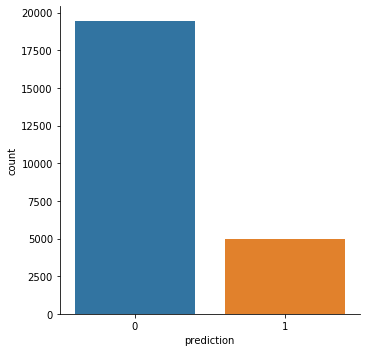

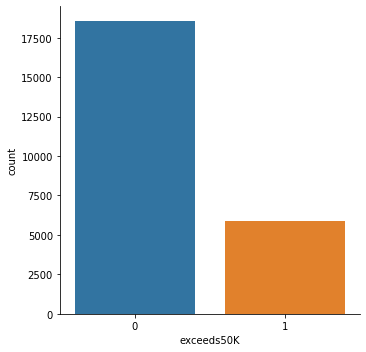

In [14]:
y_test = final_model.predict(X_test)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index += 1
df.index.name = 'id'
sns.catplot(x="prediction", kind="count", data=df)
sns.catplot(x="exceeds50K", kind="count", data=train)
df.head()

In [33]:
# experience name
experience = 'LightGBM_generatesamples'

if not os.path.exists(os.path.join('dump', experience)):
    os.mkdir(os.path.join('dump', experience))

X_train.to_csv(os.path.join('dump', experience, 'X_train.csv'))
X_test.to_csv(os.path.join('dump', experience, 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', experience, 'model'), 'wb'))
df.to_csv(os.path.join('dump', experience, experience+'.csv'))

# Feature importance

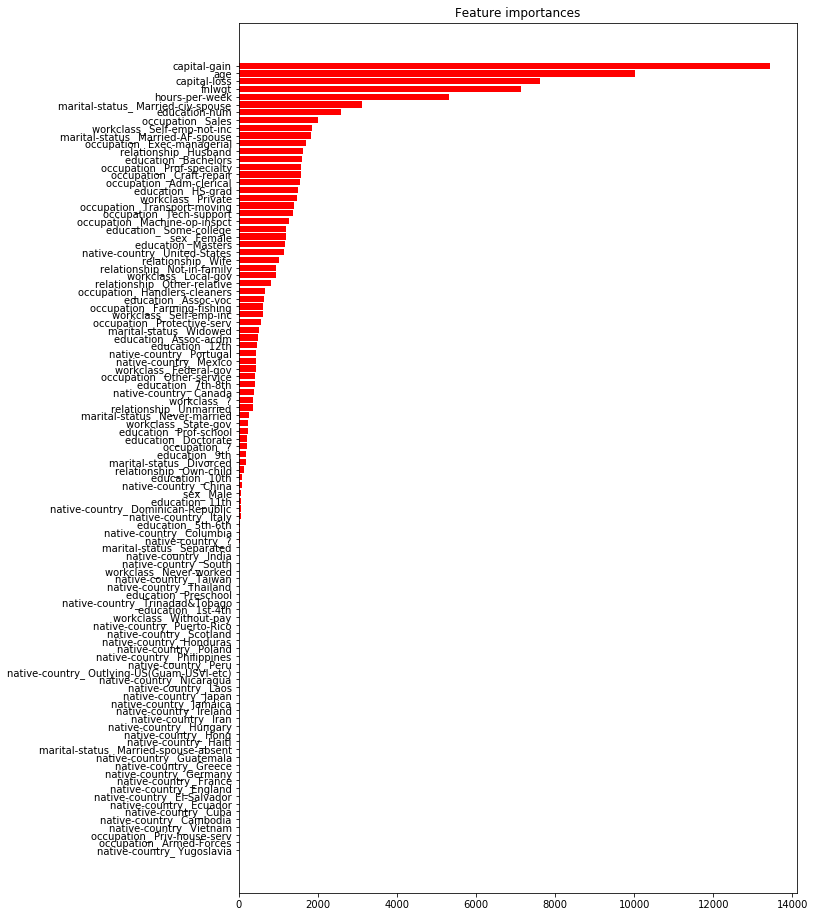

In [34]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

In [35]:
experience = 'LightGBM_generatesamples'
X_train = pd.read_csv(os.path.join('dump', experience, 'X_train.csv'), index_col=0)
final_model = pickle.load(open(os.path.join('dump', experience, 'model'), 'rb'))
lgb.create_tree_digraph(final_model).save(directory=os.path.join('dump', experience), filename='tree.dot')
call(['dot', '-Tpng', os.path.join('dump', experience, 'tree.dot'),
      '-o', os.path.join('dump', experience, 'tree.png'), '-Gdpi=600'])
# Display in jupyter notebook
Image(filename = os.path.join('dump', experience, 'tree.png'))

ImportError: You must install graphviz to plot tree.